In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
from simple_network_utils import get_mass_index

In [16]:
def PSTI(f, power, band=None, debug=False):
    """
    'Power spectral tuning index'. Signal and noise partitioned as a quantile of the power distribution. Standard
    deviation in the frequency domain is normalized to the bandwidth. Resulting frequency tuning index is proportional
    to the amplitude ratio of signal power to noise power, and inversely proportional to the standard deviation in the
    frequency domain.
    :param f: array of float; frequency (Hz)
    :param power: array of float; power spectral density (units^2/Hz)
    :param band: tuple of float
    :param debug: bool
    :return: float
    """
    if band is None:
        band = (np.min(f), np.max(f))
    band_indexes = np.where((f >= band[0]) & (f <= band[1]))[0]
    if debug:
        print('band: %s; len(f_indexes): %i' % (str(band), len(band_indexes)))
    if len(band_indexes) == 0:
        raise ValueError('PSTI: sample does not contain specified band')
    power_std = np.std(power[band_indexes])
    if power_std == 0.:
        return 0.
    bandwidth = band[1] - band[0]
    min_power = np.min(power[band_indexes]) 
    if min_power < 0.:
        raise ValueError('PTSI: power density array must be non-negative')
    if np.max(power[band_indexes]) - min_power == 0.:
        return 0.
    
    left_width_index, right_width_index = get_mass_index(power[band_indexes], 0.25), \
                                          get_mass_index(power[band_indexes], 0.75)
    if debug:
        print('left_width_index: %i, right_width_index: %i' % (left_width_index, right_width_index))
    
    norm_f_signal_width = (f[band_indexes][right_width_index] - f[band_indexes][left_width_index]) / bandwidth
    signal_indexes = np.arange(left_width_index, right_width_index, 1)
    signal_mean = np.mean(power[band_indexes][signal_indexes])
    if signal_mean == 0.:
        return 0.

    if len(signal_indexes) == 1:
        signal_std = 0.
    else:
        signal_std = np.std(power[band_indexes][signal_indexes])
    
    if debug:
        print('len(signal_indexes): %i; signal_mean: %.5f' % (len(signal_indexes), signal_mean))
    
    noise_indexes = np.delete(range(len(band_indexes)), range(left_width_index, right_width_index, 1))
    noise_mean = np.mean(power[band_indexes][noise_indexes])
    if debug:
        print('len(noise_indexes): %i; noise_mean: %.5f' % (len(noise_indexes), noise_mean))

    if noise_mean == 0. or len(noise_indexes) == 1:
        noise_std = 0.
    else:
        noise_std = np.std(power[band_indexes][noise_indexes])

    if debug:
        print 'delta_power: %.5f; norm_f_signal_width: %.5f, signal_std: %.5f, noise_std: %.5f' % \
              (signal_mean - noise_mean, norm_f_signal_width, signal_std, noise_std)
    if np.isnan(signal_std) or (signal_std + noise_std == 0.) or (norm_f_signal_width == 0.):
        return np.inf
    this_PSTI = (signal_mean - noise_mean) / (signal_mean + noise_mean) / (signal_std + noise_std) / norm_f_signal_width
    return this_PSTI

In [40]:
x = np.linspace(0., 1., 10000)
width = 0.5
sigma = width / np.sqrt(2.) / 3.

In [41]:
y = np.exp(-((x - 0.5)/sigma)**2.)


band: (0.0, 1.0); len(f_indexes): 10000
left_width_index: 4437, right_width_index: 5562
len(signal_indexes): 1125; signal_mean: 0.92897
len(noise_indexes): 8875; noise_mean: 0.11758
delta_power: 0.81139; norm_f_signal_width: 0.11251, signal_std: 0.06173, noise_std: 0.20666


<IPython.core.display.Javascript object>


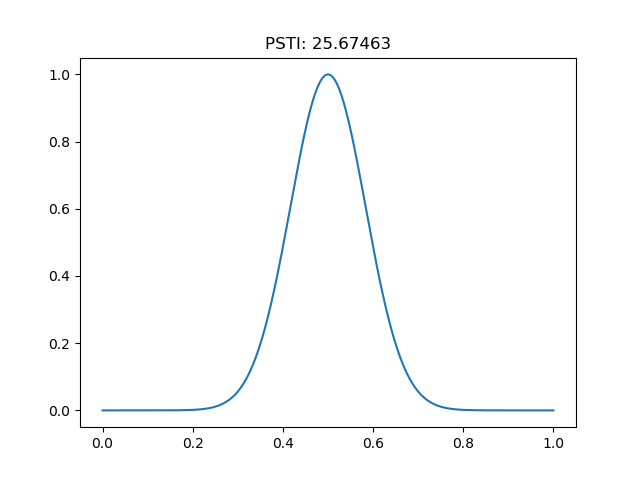

Text(0.5,1,'PSTI: 25.67463')

In [42]:
this_PSTI = PSTI(x, y, debug=True)
plt.figure()
plt.plot(x, y)
plt.title('PSTI: %.5f' % this_PSTI)